## MPF training

Below is my test code to use MPF training for a fully-connected Boltzmann machine with 32 units with no GPU consideration.

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os
import timeit

%matplotlib inline

In [2]:
def load_data(dataset = '32-50K.npy', borrow = True):
    """
    Loads the dataset.
    """

    data = np.load(dataset)
    dataset = theano.shared(np.asarray(data, dtype = theano.config.floatX), borrow = borrow)

    return dataset

In [3]:
class mpf(object):
    """
    Minimum probability flow
    """
    
    def __init__(self, input = None, n = 32, temperature = 1,  W = None, b = None):
        
        self.n = n
        self.temperature = temperature
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)
        np.fill_diagonal(R, 0)

        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)

        if not b:
            initial_b = np.asarray(np.random.rand(n), dtype = theano.config.floatX)
            b = theano.shared(initial_b, name = 'b', borrow = True)


        self.W = W
        self.b = b
        
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input

        self.params = [self.W, self.b]
    
    
    def cost(self, lr = 1e-2, epsilon = 1):
        """
        Returns the cost of vanilla SGD. 
        The update rule enforces that the W matrix at each timestep is symmetric.
        """
         
        print (51 * '=')
        print (24 * '#' + 'MPF' + 24 * '#')
        print (51 * '=')
        print ('Input size: {0}'.format(self.n))
        print ('Learning temperature: {0}'.format(self.temperature))
        print ('Learning rate: {0}'.format(lr))
        
        cost = T.mean(T.exp((0.5 - self.x) * (T.dot(self.x, self.W) + T.transpose(self.b)))) * epsilon
        Wgrad = T.grad(cost, self.W)
        bgrad = T.grad(cost, self.b)

        Wupdate = T.fill_diagonal(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T), 0)
        updates = [(self.W, Wupdate), (self.b, self.b - lr * bgrad )]
#         bupdate = self.b - lr *(T.diag(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T)) + bgrad)
#         Wupdate = T.fill_diagonal(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T), 0)        
#         updates = [(self.W, Wupdate), (self.b, bupdate)]

        return cost, updates

In [9]:
def trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '32-50K.npy'):
    """
    Trains parameters using MPF.
    """
    
    index = T.lscalar()
    x = T.matrix('x')
    flow = mpf(input = x, n = units, temperature = temperature)
    
    cost, updates = flow.cost(lr = lr, epsilon = epsilon)
    
    dataset = load_data(sample)
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batchsize

    print ('Sample used: {0}'.format(sample))
    print ('=' * 51)
    
    mpf_cost = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batchsize: (index + 1) * batchsize]})
    
    start_time = timeit.default_timer()
    
    best_mse = np.inf
    best_W = [None, np.inf]
    best_b = [None, np.inf]
    best_epoch = np.inf
    
    for epoch in range(n_epochs):
        c = []
        current_time = timeit.default_timer()
        for batch_index in range(n_dataset_batches):
            c.append(mpf_cost(batch_index))
        
        W_learnt = flow.W.get_value(borrow = True)
        b_learnt = flow.b.get_value(borrow = True)
        
        W = np.load(sample[0:2] + '-' + 'W' + '.npy')
        b = np.load(sample[0:2] + '-' + 'b' + '.npy')
        
        mseW = np.linalg.norm(W - W_learnt)/ (units**2 - units)/2
        mseb = np.linalg.norm(b - b_learnt)/ units
#         mse = (mseW * mseb)/(mseW + mseb)
        mse = mseW + mseb    
    
        if mse < best_mse:
            best_mse = mse
            best_W[0] = flow.W.get_value(borrow = True)
            best_W[1] = mseW
            best_b[0] = flow.b.get_value(borrow = True)
            best_b[1] = mseb
            best_cost = np.mean(c, dtype='float64')
            best_epoch = epoch
        
        if epoch%validate_every == 0:
            print ('Training epoch %d/%d, Cost: %f mseW: %.5f, mseb: %.5f, mse: %.5f Time Elasped: %.2f '\
                 % (epoch, n_epochs, np.mean(c, dtype='float64'), \
                 mseW, mseb, mse, (current_time - start_time)/60) )
    
    end_time = timeit.default_timer()

    training_time = end_time - start_time
    
    fig, ax = plt.subplots(2, figsize=(20,10))
    fig.tight_layout()

    ax[0].plot(W.reshape(-1,1)[0:100], 'b')
    ax[0].plot(W_learnt.reshape(-1,1)[0:100], 'r')
    ax[0].plot(best_W[0].reshape(-1,1)[0:100], 'g')
    ax[0].set_title('W')
    ax[0].legend(['W', 'Learnt W', 'Best W'])
    ax[1].plot(b.reshape(-1,1), 'b')
    ax[1].plot(b_learnt.reshape(-1,1),'r')
    ax[1].plot(best_b[0].reshape(-1,1),'g')
    ax[1].set_title('b')
    ax[1].legend(['b', 'Learnt b', 'Best b'])

    
    print ('The training took %.2f minutes' % (training_time/60.))
    print ('#' * 22 + 'Results' + '#' * 22)
    print ('=' * 51)
    print ('Best mse: {0}'.format(best_mse))
    print ('Best W mse: {0}'.format(best_W[1]))
    print ('Best b mse: {0}'.format(best_b[1]))
    print ('Best epoch: {0}'.format(best_epoch))
    print ('=' * 51)
    

########################MPF########################
Input size: 32
Learning temperature: 1
Learning rate: 0.01
Sample used: 32-50K.npy
Training epoch 0/1000, Cost: 1.835793 mseW: 0.01150, mseb: 0.18193, mse: 0.19343 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.456016 mseW: 0.00718, mseb: 0.15361, mse: 0.16078 Time Elasped: 0.42 
Training epoch 200/1000, Cost: 0.451714 mseW: 0.00608, mseb: 0.14555, mse: 0.15163 Time Elasped: 0.86 
Training epoch 300/1000, Cost: 0.450281 mseW: 0.00547, mseb: 0.14039, mse: 0.14585 Time Elasped: 1.26 
Training epoch 400/1000, Cost: 0.449573 mseW: 0.00506, mseb: 0.13673, mse: 0.14179 Time Elasped: 1.66 
Training epoch 500/1000, Cost: 0.449158 mseW: 0.00477, mseb: 0.13408, mse: 0.13885 Time Elasped: 2.05 
Training epoch 600/1000, Cost: 0.448889 mseW: 0.00455, mseb: 0.13215, mse: 0.13670 Time Elasped: 2.44 
Training epoch 700/1000, Cost: 0.448703 mseW: 0.00439, mseb: 0.13074, mse: 0.13513 Time Elasped: 2.84 
Training epoch 800/1000, Cost: 0.448565 mse

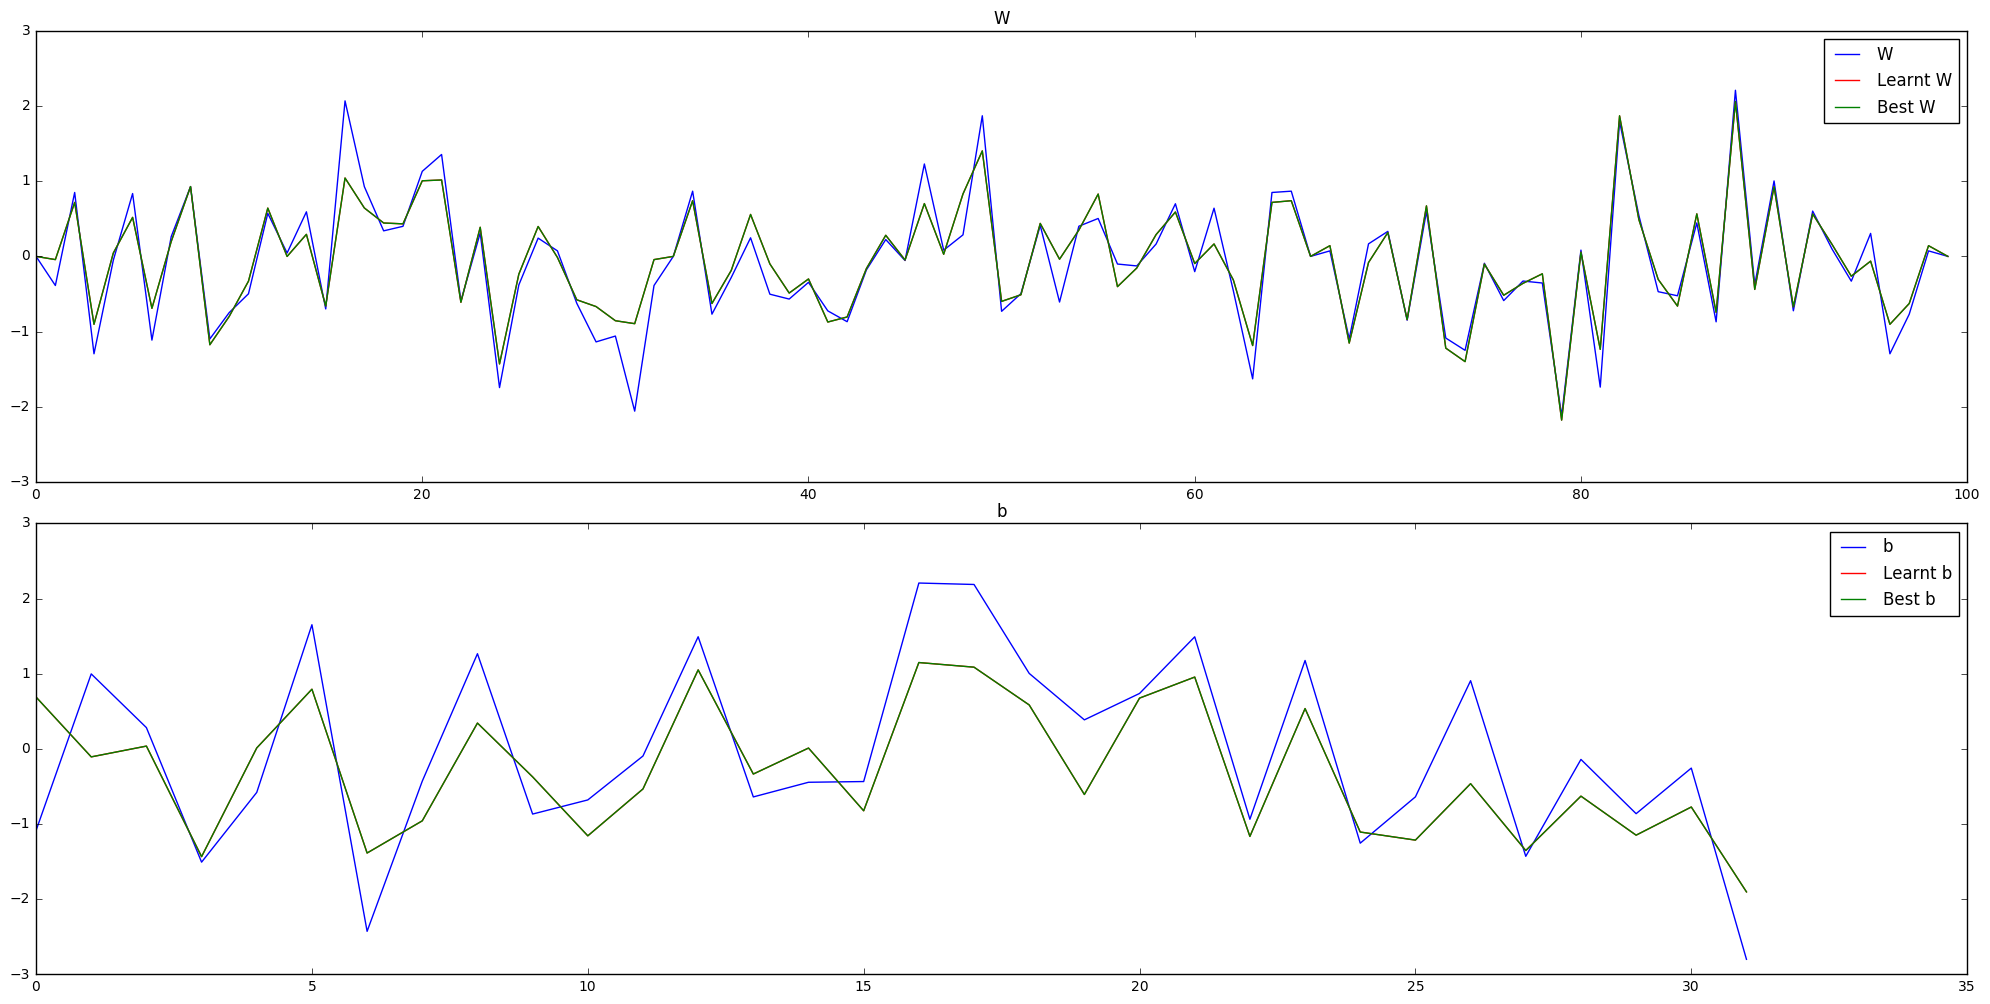

In [11]:
trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '32-50K.npy')

########################MPF########################
Input size: 32
Learning temperature: 1.5
Learning rate: 0.01
Sample used: 32-50K.npy
Training epoch 0/1000, Cost: 1.786385 mseW: 0.01141, mseb: 0.18792, mse: 0.19933 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.455860 mseW: 0.00710, mseb: 0.15733, mse: 0.16443 Time Elasped: 0.41 
Training epoch 200/1000, Cost: 0.451593 mseW: 0.00602, mseb: 0.15020, mse: 0.15622 Time Elasped: 0.80 
Training epoch 300/1000, Cost: 0.450194 mseW: 0.00541, mseb: 0.14539, mse: 0.15080 Time Elasped: 1.20 
Training epoch 400/1000, Cost: 0.449507 mseW: 0.00502, mseb: 0.14181, mse: 0.14683 Time Elasped: 1.59 
Training epoch 500/1000, Cost: 0.449107 mseW: 0.00474, mseb: 0.13909, mse: 0.14383 Time Elasped: 1.99 
Training epoch 600/1000, Cost: 0.448849 mseW: 0.00454, mseb: 0.13700, mse: 0.14154 Time Elasped: 2.38 
Training epoch 700/1000, Cost: 0.448669 mseW: 0.00438, mseb: 0.13539, mse: 0.13977 Time Elasped: 2.78 
Training epoch 800/1000, Cost: 0.448537 m

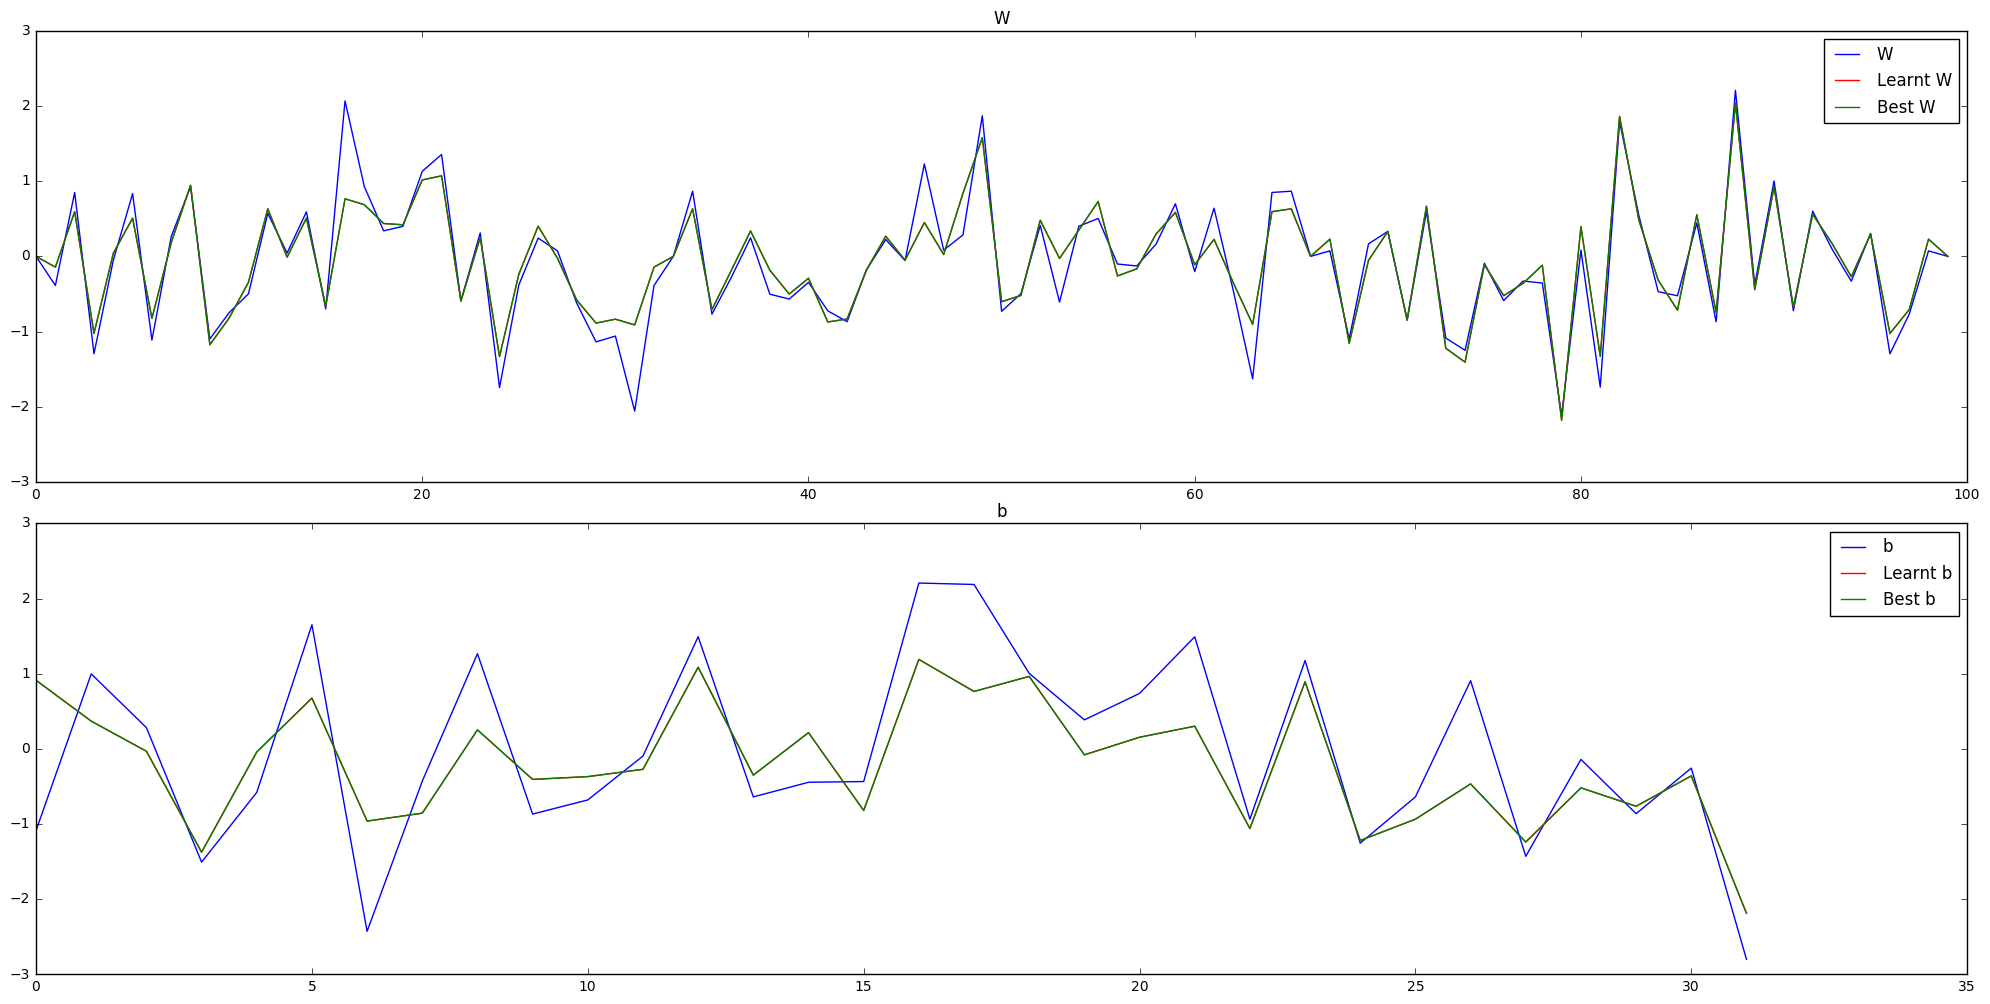

In [13]:
trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1.5, validate_every = 100, sample = '32-50K.npy')

########################MPF########################
Input size: 32
Learning temperature: 1.75
Learning rate: 0.01
Sample used: 32-50K.npy
Training epoch 0/1000, Cost: 1.815869 mseW: 0.01167, mseb: 0.17936, mse: 0.19103 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.456215 mseW: 0.00727, mseb: 0.15219, mse: 0.15945 Time Elasped: 0.46 
Training epoch 200/1000, Cost: 0.451787 mseW: 0.00614, mseb: 0.14460, mse: 0.15074 Time Elasped: 0.85 
Training epoch 300/1000, Cost: 0.450306 mseW: 0.00550, mseb: 0.13921, mse: 0.14471 Time Elasped: 1.25 
Training epoch 400/1000, Cost: 0.449575 mseW: 0.00509, mseb: 0.13512, mse: 0.14020 Time Elasped: 1.64 
Training epoch 500/1000, Cost: 0.449150 mseW: 0.00480, mseb: 0.13195, mse: 0.13675 Time Elasped: 2.04 
Training epoch 600/1000, Cost: 0.448876 mseW: 0.00459, mseb: 0.12949, mse: 0.13407 Time Elasped: 2.43 
Training epoch 700/1000, Cost: 0.448687 mseW: 0.00443, mseb: 0.12754, mse: 0.13197 Time Elasped: 2.87 
Training epoch 800/1000, Cost: 0.448548 

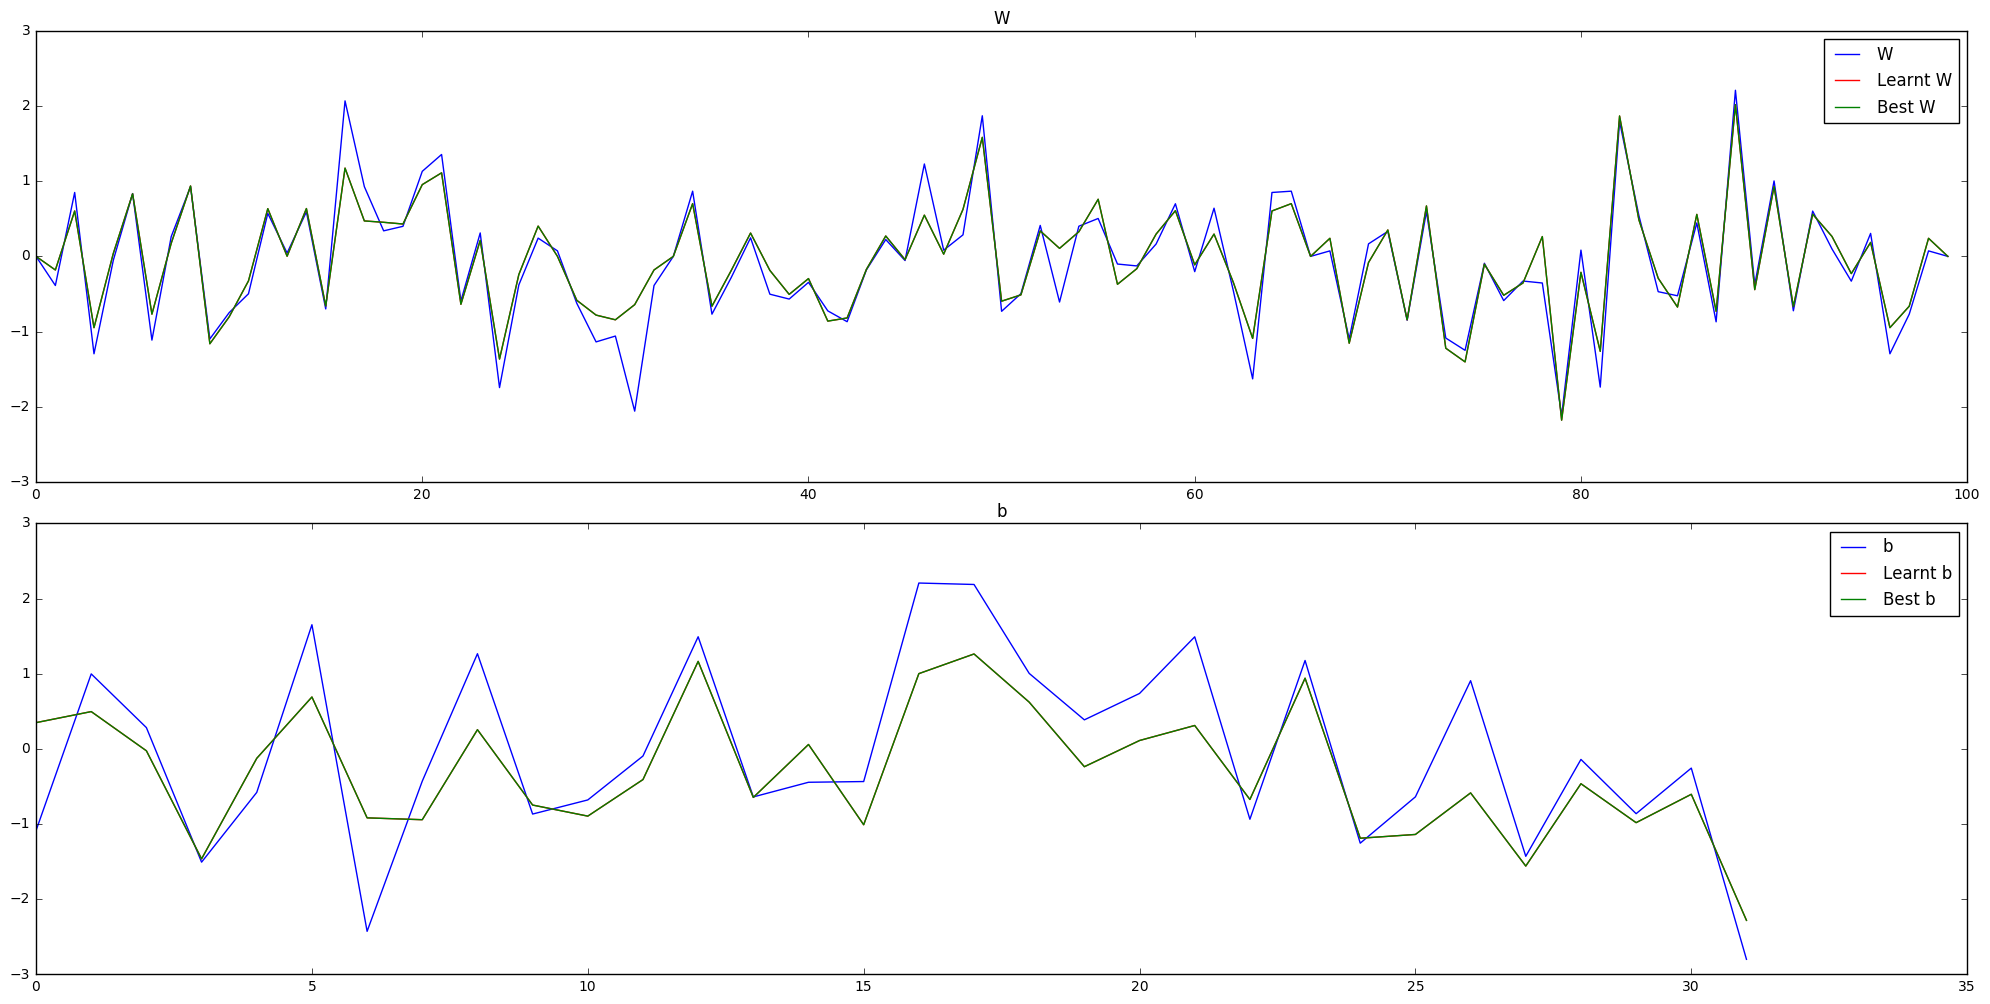

In [14]:
trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1.75, validate_every = 100, sample = '32-50K.npy')

########################MPF########################
Input size: 32
Learning temperature: 2
Learning rate: 0.01
Sample used: 32-50K.npy
Training epoch 0/1000, Cost: 1.792889 mseW: 0.01139, mseb: 0.20703, mse: 0.21843 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.455787 mseW: 0.00703, mseb: 0.17641, mse: 0.18345 Time Elasped: 0.40 
Training epoch 200/1000, Cost: 0.451550 mseW: 0.00597, mseb: 0.16790, mse: 0.17387 Time Elasped: 0.80 
Training epoch 300/1000, Cost: 0.450160 mseW: 0.00538, mseb: 0.16191, mse: 0.16729 Time Elasped: 1.19 
Training epoch 400/1000, Cost: 0.449479 mseW: 0.00500, mseb: 0.15730, mse: 0.16231 Time Elasped: 1.58 
Training epoch 500/1000, Cost: 0.449084 mseW: 0.00474, mseb: 0.15368, mse: 0.15842 Time Elasped: 1.98 
Training epoch 600/1000, Cost: 0.448830 mseW: 0.00455, mseb: 0.15078, mse: 0.15533 Time Elasped: 2.37 
Training epoch 700/1000, Cost: 0.448655 mseW: 0.00440, mseb: 0.14845, mse: 0.15285 Time Elasped: 2.76 
Training epoch 800/1000, Cost: 0.448526 mse

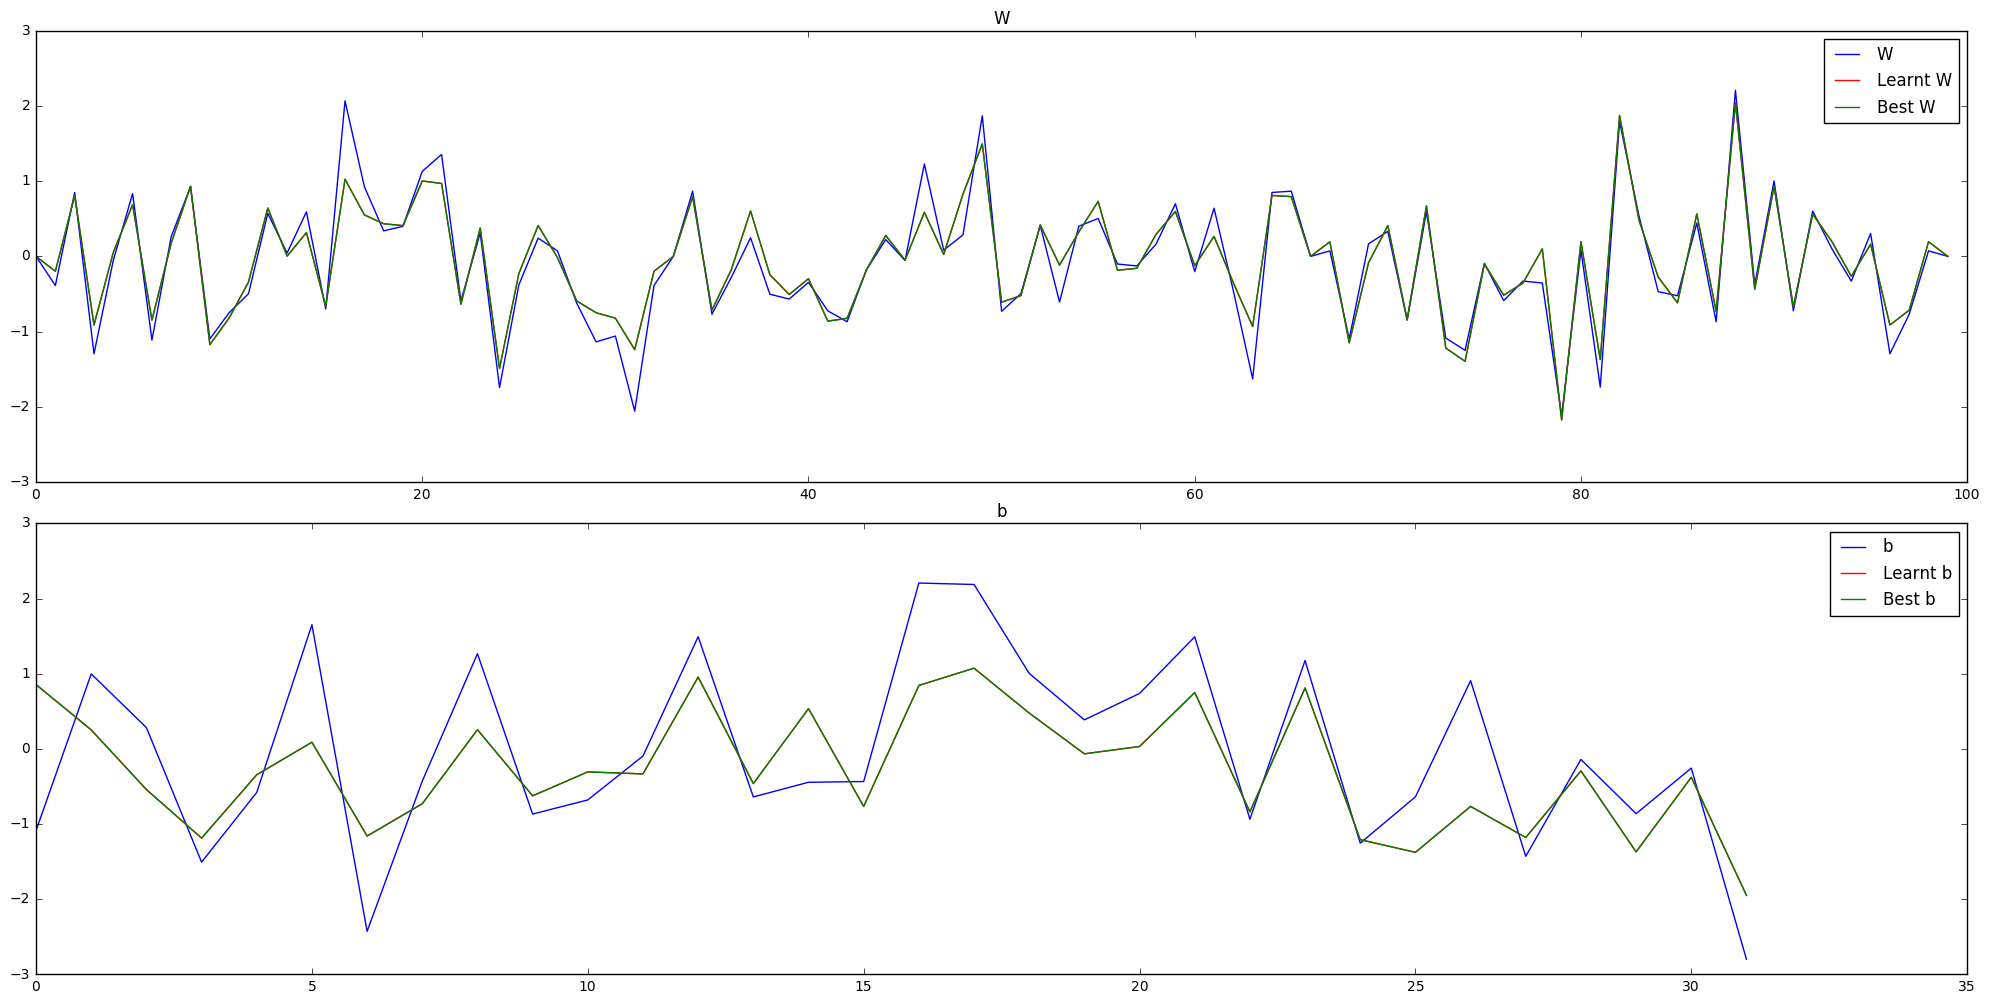

In [15]:
trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 2, validate_every = 100, sample = '32-50K.npy')